In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [6]:
df = pd.read_csv('C:/Users/marie/Desktop/mariem/work/essaie/venv/monthly_milk_production.csv',index_col='Date',parse_dates=True)
df.index.freq='MS'

In [7]:
df.head()

,Production
Date,
1962-01-01,589
1962-02-01,561
1962-03-01,640
1962-04-01,656
1962-05-01,727


<AxesSubplot:xlabel='Date'>

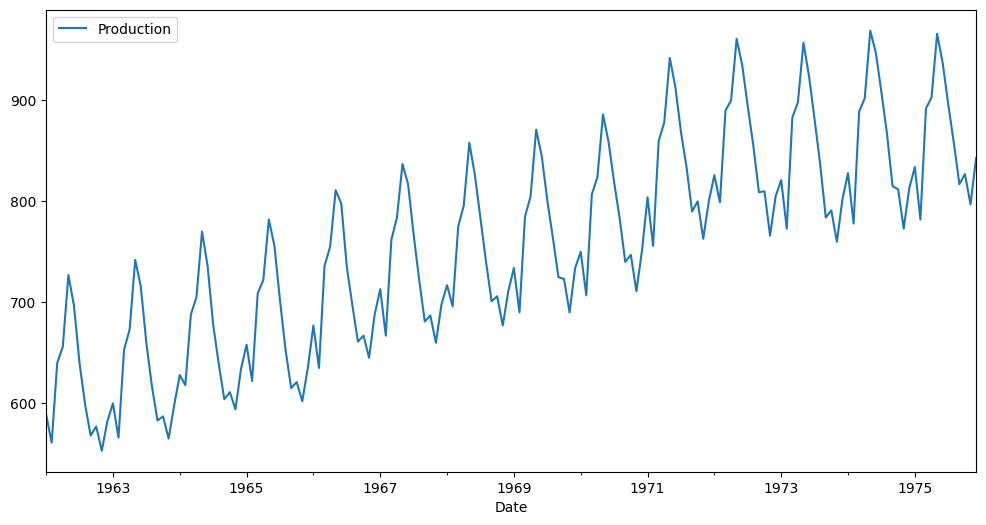

In [8]:
df.plot(figsize=(12,6))

Seasonal decompose
Graph: isolating the trend and removing the seasonal pattern; general increasing of trend with time & clear seasonal pattern & the noise part

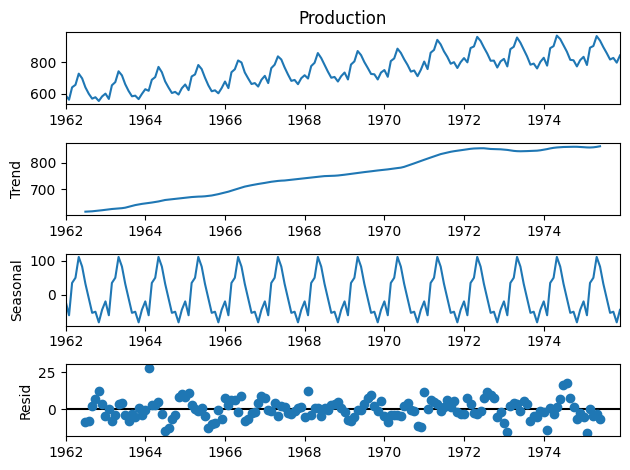

In [9]:

from statsmodels.tsa.seasonal import seasonal_decompose
     

results = seasonal_decompose(df['Production'])
results.plot();

In [10]:
len(df)


168

In [11]:
train = df.iloc[:156]
test = df.iloc[156:]

Preprocessing
converting the dataset into a scale from 0 to 1


In [12]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
     

In [13]:
df.head(),df.tail()


(            Production
 Date                  
 1962-01-01         589
 1962-02-01         561
 1962-03-01         640
 1962-04-01         656
 1962-05-01         727,
             Production
 Date                  
 1975-08-01         858
 1975-09-01         817
 1975-10-01         827
 1975-11-01         797
 1975-12-01         843)

Train & Test


In [14]:
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [15]:
scaled_train[:10]

array([[0.08653846],
       [0.01923077],
       [0.20913462],
       [0.24759615],
       [0.41826923],
       [0.34615385],
       [0.20913462],
       [0.11057692],
       [0.03605769],
       [0.05769231]])

In [16]:
from keras.preprocessing.sequence import TimeseriesGenerator

define generator

In [18]:

n_input = 12
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [19]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [20]:

# define model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [21]:

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               40800     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


Fit Model

In [22]:

model.fit(generator,epochs=50)

Epoch 1/50
144/144 [==============================] - 1s 2ms/step - loss: 0.0404
Epoch 2/50
144/144 [==============================] - 0s 2ms/step - loss: 0.0253
Epoch 3/50
144/144 [==============================] - 0s 2ms/step - loss: 0.0148
Epoch 4/50
144/144 [==============================] - 0s 2ms/step - loss: 0.0085
Epoch 5/50
144/144 [==============================] - 0s 2ms/step - loss: 0.0068
Epoch 6/50
144/144 [==============================] - 0s 2ms/step - loss: 0.0038
Epoch 7/50
144/144 [==============================] - 0s 2ms/step - loss: 0.0042
Epoch 8/50
144/144 [==============================] - 0s 2ms/step - loss: 0.0041
Epoch 9/50
144/144 [==============================] - 0s 2ms/step - loss: 0.0043
Epoch 10/50
144/144 [==============================] - 0s 2ms/step - loss: 0.0037
Epoch 11/50
144/144 [==============================] - 0s 2ms/step - loss: 0.0035
Epoch 12/50
144/144 [==============================] - 0s 2ms/step - loss: 0.0050
Epoch 13/50
144/144 [====

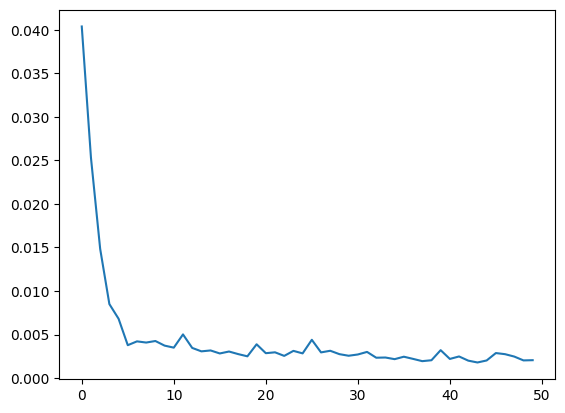

In [23]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

the loss has been decreasing with every epoch


In [24]:

last_train_batch = scaled_train[-12:]


In [25]:
last_train_batch = last_train_batch.reshape((1, n_input, n_features))

In [26]:
model.predict(last_train_batch)

1/1 [==============================] - 0s 136ms/step


array([[0.712281]], dtype=float32)

In [ ]:

scaled_test[0]

array([0.67548077])

In [ ]:
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):
    
    # get the prediction value for the first batch
    current_pred = model.predict(current_batch)[0]
    
    # append the prediction into the array
    test_predictions.append(current_pred) 
    
    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 [==============================] - 0s 18ms/step


In [ ]:
test_predictions


[array([0.6330393], dtype=float32),
 array([0.64689046], dtype=float32),
 array([0.79537505], dtype=float32),
 array([0.86612797], dtype=float32),
 array([0.9321219], dtype=float32),
 array([0.92909354], dtype=float32),
 array([0.88313484], dtype=float32),
 array([0.793927], dtype=float32),
 array([0.687551], dtype=float32),
 array([0.628363], dtype=float32),
 array([0.5875192], dtype=float32),
 array([0.6145019], dtype=float32)]

In [ ]:
test.head()


,Production
Date,
1975-01-01,834
1975-02-01,782
1975-03-01,892
1975-04-01,903
1975-05-01,966


Transform back to the original scale

In [ ]:

true_predictions = scaler.inverse_transform(test_predictions)

In [ ]:
test['Predictions'] = true_predictions


C:\Users\marie\AppData\Local\Temp\ipykernel_17472\2515899287.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = true_predictions


<AxesSubplot:xlabel='Date'>

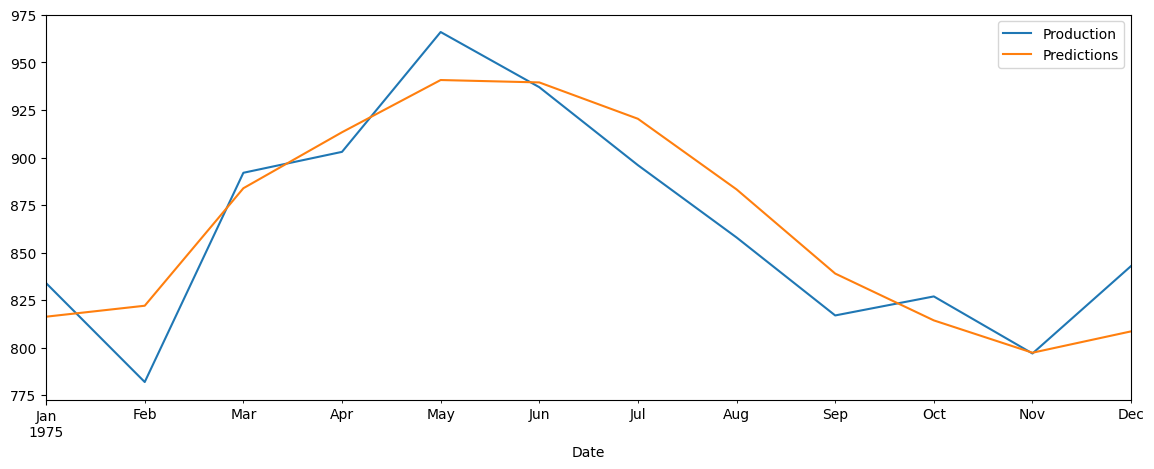

In [ ]:
test.plot(figsize=(14,5))

Calculating Mean squared Error

In [ ]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse=sqrt(mean_squared_error(test['Production'],test['Predictions']))
print(rmse)

21.97355423442908
